In [1]:
import pyabc
import matplotlib.pyplot as plt
import os
import tempfile
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as MSE

In [2]:
class smc_abc:
    def __init__(self,model,dist_func, yobs, priors,population_size,min_dist,max_ite):
        self.model           = model
        self.dist_func       = dist_func
        self.priors          = priors
        self.population_size = population_size
        self.yobs            = yobs
        self.min_dist = min_dist
        self.max_ite  = max_ite

    def run(self):
        abc = pyabc.ABCSMC(models=self.model,
                     parameter_priors=self.priors,
                     distance_function=self.dist_func,
                     sampler=pyabc.SingleCoreSampler(),
                     population_size=self.population_size)
        db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test1.db"))
        os.system('rm '+db_path)
        abc.new(db_path, self.yobs)
        self.history = abc.run(minimum_epsilon=self.min_dist, max_nr_populations=self.max_ite)

In [11]:
def plot_params_bar(results,true_params):
    df,w = results.history.get_distribution()
    cols = list(df.columns)
    cols.sort()
    df = df.loc[:,cols]
    
    pos = np.arange(len(cols))*3
    
    plt.figure(figsize=(10,3))
    plt.bar(pos,[true_params[col] for col in cols],label='True',zorder=1)
    plt.bar(pos+1,[np.median(df[col]) for col in cols],label='Post',zorder=1)
    
    
    for i,col in enumerate(cols):
        plt.scatter([pos[i]]*df.shape[0]+np.random.normal(1,0.01,size=df.shape[0]),
                    df[col],color='gray',alpha=0.5,s=5,zorder=2)
    plt.legend()
    plt.xlabel('Parameters')
    plt.ylabel('Values')
    plt.show()
        

In [8]:
def plot_training_curve(results,outname=None,logy=False):
    eps = []
    for i in range(results.history.max_t+1):
        df,w = results.history.get_distribution(t=i)
        dists = []
        for ind in df.index:
            param = {col:df.loc[ind,col] for col in df.columns}
            dist  = results.dist_func(results.model(param), results.yobs)
            dists.append(dist)
        eps.append(np.median(dists))
    
    plt.figure(figsize=(3,2.6))
    plt.scatter(np.arange(len(eps)),eps) 
    if logy: plt.yscale('log')
    plt.xlabel('Iterations')
    plt.ylabel('Median MSE')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

### Test

In [12]:
def run_test():
    def model(param):
     # {'p0':,'p1':,...}
        p = np.array([param['p{0}'.format(i)] for i in range(len(param))])

        res = np.dot(x_exp,np.transpose(p))

        return {'data': res}
    
    def distance(x,y):
        return MSE(x['data'],y['data'])
    
    param_num = 10
    population_size = 100
    training_samples =  100
    priors = pyabc.Distribution(**{'p{0}'.format(i):pyabc.RV('norm',0,1) for i in range(param_num)})
    
    training_samples = 10
    x_exp       = np.random.normal(size=(training_samples,param_num))
    true_params = {'p{0}'.format(i): np.random.uniform() for i in range(param_num)}
    y_exp       = model(true_params)
    y_exp['data'] +=  np.random.normal(scale=0.1,size=training_samples)
    
    test = smc_abc(model,
               distance,
               y_exp,
               priors,
               population_size,
               min_dist=0,
               max_ite=50) 
    test.run()
    plot_training_curve(test)
    plot_params_bar(test,true_params)

INFO:History:Start <ABCSMC(id=15, start_time=2020-09-21 13:57:46.126835, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 9.276102303828965
INFO:ABC:t: 0, eps: 9.276102303828965.
INFO:ABC:Acceptance rate: 100 / 208 = 4.8077e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 6.4057950522013325.
INFO:ABC:Acceptance rate: 100 / 273 = 3.6630e-01, ESS=1.4159e+01.
INFO:ABC:t: 2, eps: 4.7722624770962865.
INFO:ABC:Acceptance rate: 100 / 281 = 3.5587e-01, ESS=1.1644e+01.
INFO:ABC:t: 3, eps: 3.6057863546892097.
INFO:ABC:Acceptance rate: 100 / 297 = 3.3670e-01, ESS=2.5648e+01.
INFO:ABC:t: 4, eps: 2.566928937697584.
INFO:ABC:Acceptance rate: 100 / 360 = 2.7778e-01, ESS=3.9525e+00.
INFO:ABC:t: 5, eps: 2.3184386187284898.
INFO:ABC:Acceptance rate: 100 / 247 = 4.0486e-01, ESS=2.6045e+00.
INFO:ABC:t: 6, eps: 2.2369881381148815.
INFO:ABC:Acceptance rate: 100 / 244 = 4.0984e-01, ESS=1.9220e+00.
INFO:ABC:t: 7, eps: 1.495795565873999.
INFO:ABC:Acceptance rate: 100 / 307 = 3.25

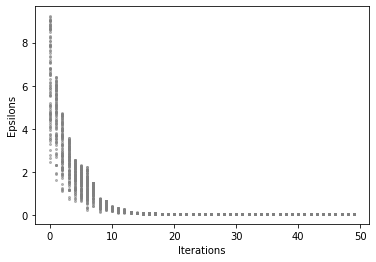

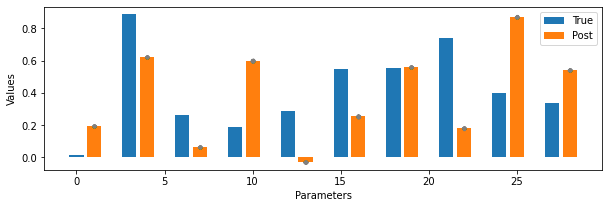

In [13]:
if __name__ == '__main__': run_test()